## Project3

### 分析题目和读取数据

已知题目中，有7070个基因，69个个体样本   
一共标签种类有['MED' 'MGL' 'RHB' 'EPD' 'JPA'] 这五种, 其中MED中有一个标签是错的

在测试集中一共有23个样本个体，该类型的属于基于少量样本得出的预测，依赖特征信息较多。

In [3]:

import pandas as pd
from os.path import join as opj
import numpy as np 
import os

# analysis the data

curPath = os.path.abspath(os.path.dirname(__file__))
data_source = opj(curPath, 'data')

# data_source = 'data'
train_data_file = opj(data_source, 'pp5i_train.gr.csv')
test_data_file = opj(data_source, 'pp5i_test.gr.csv')
label_file = opj(data_source, 'pp5i_train_class.txt')
label = pd.read_table(label_file)

train = pd.read_csv(train_data_file)
test = pd.read_csv(test_data_file)
names = pd.DataFrame(columns=['SNO'])
names['SNO'] = train['SNO']
names = names.reset_index(drop=True) # for mapping the number to actual name



train.drop(columns=['SNO'], inplace=True) # drop the columns of gene name
test.drop(columns=['SNO'], inplace=True) # the order of gene name are the same as train list, drop as well.
train = train.transpose().reset_index(drop=True)
test = test.transpose().reset_index(drop=True)  # transpose the matrix for more covineient analysis
label = pd.Series(label['Class']) # get the label

train.columns = names['SNO']
test.columns = names['SNO']
print(label.unique())
# train.describe()

NameError: name 'os' is not defined

#### 数据预处理
1. 查看缺失值,重复值 （无缺失值，无重复值）
2. 查看异常值

In [91]:
train[train.isnull().values==True]
test[test.isnull().values==True]

SNO,A28102_at,AB000114_at,AB000115_at,AB000220_at,AB000409_at,AB000449_at,AB000450_at,AB000460_at,AB000462_at,AB000464_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at


In [92]:
train.duplicated().value_counts()
test.duplicated().value_counts()

False    23
dtype: int64

### 分析
#### 基于卡方检验的基因选择
经过实验发现，卡方检验排名4000以后的基因对模型性能未见显著影响，可以舍去

In [124]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

num_feats = 3500

X_norm = MinMaxScaler().fit_transform(train)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = train.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')


train = train.loc[:, chi_support]

train = MinMaxScaler().fit_transform(train)

3500 selected features


#### 基于k折验证的xgboost检验

在训练集中，对半划分训练结果精度 以及 5折验证得到的平均精度结果

最小最大归一化对结果未见显著影响

In [138]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn import metrics
from  sklearn.datasets  import  make_hastie_10_2
from xgboost.sklearn import XGBClassifier

X, y = train, label

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold,cross_val_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)##test_size测试集合所占比例
clf = XGBClassifier(

silent=0 ,#设置成1则没有运行信息输出，最好是设置为0.是否在运行升级时打印消息。
#nthread=4,# cpu 线程数 默认最大
learning_rate= 0.2, # 如同学习率
min_child_weight=1, 
# 这个参数默认是 1，是每个叶子里面 h 的和至少是多少，对正负样本不均衡时的 0-1 分类而言
#，假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本。
#这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易 overfitting。
max_depth=6, # 构建树的深度，越大越容易过拟合
gamma=0,  # 树的叶子节点上作进一步分区所需的最小损失减少,越大越保守，一般0.1、0.2这样子。
subsample=1, # 随机采样训练样本 训练实例的子采样比
max_delta_step=0,#最大增量步长，我们允许每个树的权重估计。
colsample_bytree=1, # 生成树时进行的列采样 
reg_lambda=1,  # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
#reg_alpha=0, # L1 正则项参数
#scale_pos_weight=1, #如果取值大于0的话，在类别样本不平衡的情况下有助于快速收敛。平衡正负权重
#objective= 'multi:softmax', #多分类的问题 指定学习任务和相应的学习目标
#num_class=10, # 类别数，多分类与 multisoftmax 并用
n_estimators=100, #树的个数
seed=1000 #随机种子
#eval_metric= 'auc'
 )

clf.fit(X_train,y_train,eval_metric='auc')

y_true, y_pred = y_test, clf.predict(X_test)
print("Accuracy : %.4g" % metrics.accuracy_score(y_true, y_pred))

# N fold evaluation 
print('-------N fold evaluation ---------')
# Kf = KFold(n_splits=3, shuffle=True)
strKFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(clf, train, label, cv=strKFold)

print("straitified cross validation scores:{}".format(scores))
print("Mean score of straitified cross validation:{:.2f}".format(scores.mean()))

Accuracy : 0.8857
-------N fold evaluation ---------
straitified cross validation scores:[0.9375     0.73333333 0.92307692 1.         0.83333333]
Mean score of straitified cross validation:0.89


In [145]:
np.array(y_true)

array(['EPD', 'MED', 'MGL', 'MGL', 'MED', 'MED', 'MED', 'MED', 'JPA',
       'MED', 'MED', 'MGL', 'MED', 'MED', 'EPD', 'EPD', 'EPD', 'MED',
       'JPA', 'JPA', 'MED', 'MED', 'MED', 'MED', 'MED', 'MED', 'JPA',
       'MED', 'JPA', 'EPD', 'RHB', 'MED', 'MED', 'MED', 'MED'],
      dtype=object)

In [146]:
y_pred

array(['MED', 'MED', 'EPD', 'MGL', 'MED', 'MED', 'MED', 'MED', 'JPA',
       'MED', 'MED', 'MGL', 'MED', 'MED', 'EPD', 'RHB', 'EPD', 'MED',
       'EPD', 'JPA', 'MED', 'MED', 'MED', 'MED', 'MED', 'MED', 'JPA',
       'MED', 'JPA', 'EPD', 'RHB', 'MED', 'MED', 'MED', 'MED'],
      dtype=object)

#### 基于树模型的基因重要性分析

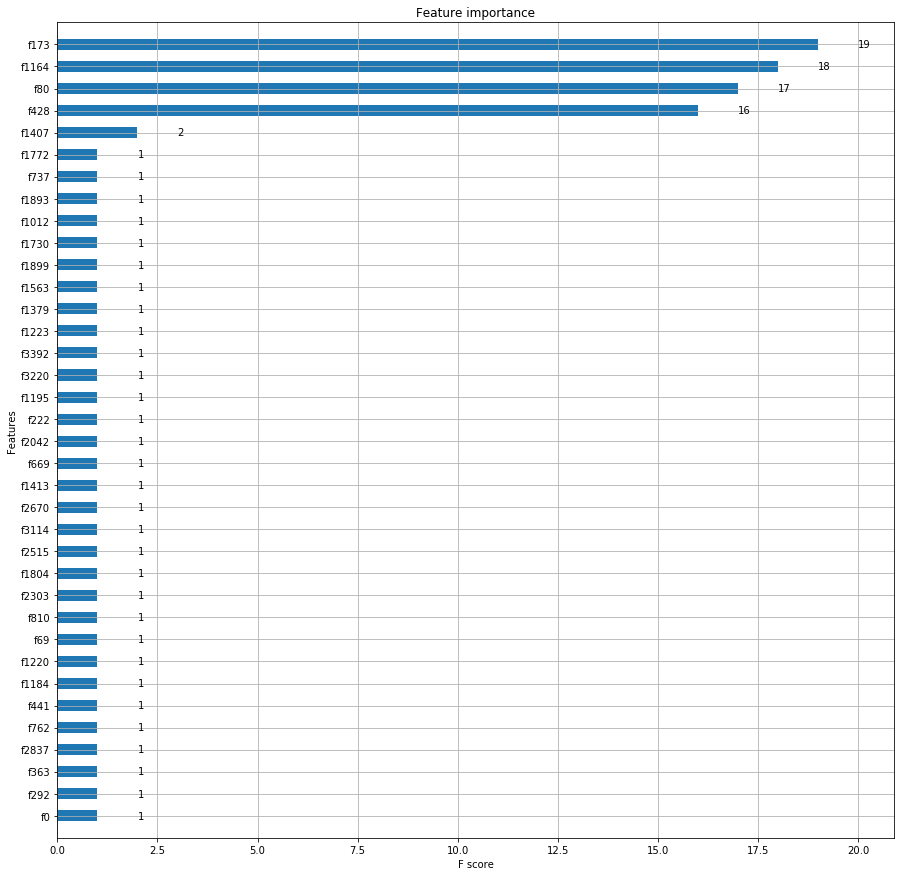

In [144]:
from xgboost import plot_importance
from matplotlib import pyplot as plt

fig,ax = plt.subplots(figsize=(15,15))
plot_importance(clf, ax=ax, height=0.5, max_num_features=40)
plt.show()